In [3]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import re
import pickle
import boto
from copy import deepcopy
import json
import os
import random
import jinja2
from tqdm import tqdm
from IPython.core.display import HTML

import PIL.Image as Image
import requests

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo

from amt_utils.mturk import pickle_this, unpickle_this

import os
import jinja2
import argparse
from jinja2 import Environment, FileSystemLoader

j2env = jinja2.Environment()

from amt_utils.bboxes import cluster_from_nms
from amt_utils.bboxes import draw_animation_seq
from amt_utils.bboxes import cluster_from_annos
from amt_utils.bboxes import create_subtask_data
from amt_utils.bboxes import draw_image_and_labels
from amt_utils.bboxes import select_labels
from amt_utils.bboxes import cluster_and_label
import warnings
warnings.filterwarnings('ignore')

In [4]:
import ai2.vision.utils as ai2vu

# load data

In [5]:
data_paths = ['./pickeled_results/turker_batch_{}.pkl'.format(i) for i in range(1,6)]

turk_data_assemble = [unpickle_this(data_path) for data_path in data_paths]

batch_2 = turk_data_assemble[0]
batch_2 = turk_data_assemble[1]
batch_3 = turk_data_assemble[2]
batch_4 = turk_data_assemble[3]
batch_5 = turk_data_assemble[4]
batch_8 = unpickle_this('./pickeled_results/turker_batch_8.pkl')

turk_data = {}
_ = [turk_data.update(data_part) for data_part in turk_data_assemble + [batch_8]]

# all_so_far = unpickle_this('./pickeled_results/turker_all_subtask_8_12.pkl')

In [6]:
len(batch_8)

1632

In [5]:
prod_batch_1_4 = unpickle_this('./pickeled_results/prod_batch_1_4.pkl')
# turk_data = {}
# _ = [turk_data.update(data_part) for data_part in [prod_batch_1_4]]
turk_data = prod_batch_1_4

In [6]:
len(turk_data)

20000

# process data

In [123]:
main_characters =  {"fred",
             "barney",
              "wilma",
              "betty",
              "pebbles",
              "bamm bamm",
              "dino",
              "mr slate",
              "baby puss",
              "hoppy",
              "empty frame",
              "no characters"}

def create_result(assmt):
    result = json.loads(assmt.answers[0][0].fields[0])
    result['h_id'] = assmt.HITId
    result['asgmt_id'] = assmt.AssignmentId
    result['worker_id'] = assmt.WorkerId
    return result


def all_main(char_set, main_chars=main_characters):
    return not bool(char_set.difference(main_chars))


def no_main(char_set, main_chars=main_characters):
    return len(char_set.difference(main_chars)) == len(char_set)

In [9]:
assignments =[]
for assignment_triple in list(turk_data.values()):
    assignments.extend(assignment_triple)

assignment_results = [create_result(ar) for ar in assignments]
characters_present = [{'h_id': anno['h_id'], 'asgnmt_id': anno['asgmt_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

In [10]:
annotations_by_frame = defaultdict(list)
for anno in sorted(assignment_results, key=lambda x: x['stillID']):
    animation_id = anno['stillID'].rsplit('_', 1)[0]
    annotations_by_frame[animation_id].append(anno)

In [11]:
annotations_by_frame['s_04_e_26_shot_033493_033567']

annotations_by_frame['s_01_e_22_shot_018599_018673']

annotations_by_frame['s_05_e_09_shot_017587_017661']

[{'asgmt_id': '38YMOXR4MVZPQ8PWYDYBED0LR6K6WS',
  'characterBoxes': '[{"left":93,"top":51,"width":358,"height":409,"label":"mr slate"}]',
  'h_id': '3QREJ3J434XDR90S61G8Q1T2878KLI',
  'stillID': 's_04_e_26_shot_033493_033567_40.png',
  'worker_id': 'A2X7BE2FSPUKCK'},
 {'asgmt_id': '3G0WWMR1UWKSDWZ2LLLMOZ4LYVTNQG',
  'characterBoxes': '[{"left":155,"top":76,"width":274,"height":404,"label":"fred"}]',
  'h_id': '3QREJ3J434XDR90S61G8Q1T2878KLI',
  'stillID': 's_04_e_26_shot_033493_033567_40.png',
  'worker_id': 'A3MD34XEB4H6JF'},
 {'asgmt_id': '3Z4AIRP3C7D98MTP2CIGL0NBSXB1XJ',
  'characterBoxes': '[{"left":105,"top":61,"width":431,"height":419,"label":"barney"}]',
  'h_id': '3QREJ3J434XDR90S61G8Q1T2878KLI',
  'stillID': 's_04_e_26_shot_033493_033567_40.png',
  'worker_id': 'A2CXEAMWU2SFV3'}]

# bonuses

In [599]:
reject_variations = {
    "otherchar",
    "0ther",
    "schwenk",
}

In [600]:
def filter_rejects(chars):
    genuine_bonus = []
    reject = []
    for char in chars:
        comp_string = ''.join(c for c in char if c.isalnum()).lower()
        reject_chars = [char for var in reject_variations if var in char.replace(' ','')]
        if reject_chars or len(char.replace(' ','')) < 3:
            reject.extend(reject_chars)
        else:
            genuine_bonus.append(char)
    return reject, genuine_bonus

def assign_bonuses(assignments):
    bonuses = {}
    rejections = {}
    worker_lookup = {}
    all_descriptions = []
    for asgmt in assignments:
        aid = asgmt.AssignmentId
        worker_id = asgmt.WorkerId
        worker_lookup[aid] = worker_id
        result = create_result(asgmt)
        all_descriptions.extend([char['label'] for char in json.loads(result['characterBoxes'])])
        bonus_chars = [char['label'] for char in json.loads(result['characterBoxes']) if char['label'] not in main_characters]
        rejects, bonus_chars = filter_rejects(bonus_chars)
        if rejects:
            rejections[aid] = (rejects, bonus_chars)
        elif bonus_chars:
            bonuses[aid] = len(bonus_chars)
#             bonuses[aid] = bonus_chars
    return bonuses, rejections, worker_lookup, all_descriptions

In [603]:
worker_counts = pd.Series(list(asgmt_workers.values())).value_counts()

In [604]:
sum(worker_counts > 50)

248

In [602]:
bonuses, to_reject, asgmt_workers, all_descriptions = assign_bonuses(assignments)

In [605]:
len(assignments)

59836

In [606]:
all_rejections = []
for chars in to_reject.values():
    all_rejections.extend(chars[0])

In [607]:
all_rejections

['main characters and other characters',
 'main characters and other characters',
 'main characters and other characters',
 'main characters and other characters',
 'main characters and other characters',
 'other character',
 'main characters and other characters',
 'main charactrers and other characters',
 'other character',
 'other character',
 'main characters and other characters']

In [609]:
pd.Series(list(bonuses.values())).sum() * 0.01

151.53999999999999

In [379]:
# pickle_this(bad_aids, 'to_reject.pkl')

In [380]:
# pd.Series(all_rejections).value_counts()

In [611]:
bad_aids = set(to_reject.keys())

In [612]:
len(bad_aids)

11

In [613]:
bad_workers = set([asgmt_workers[aid] for aid in bad_aids])
len(bad_workers)

bad_workers

{'A1HL8LE2075V80', 'A1WHEV7QAX73IC'}

In [614]:
worker_bonuses = defaultdict(int)
for aid, char_count in bonuses.items():
    worker_bonuses[aid] = {
        'count': char_count,
        'worker_id': asgmt_workers[aid]
    }

In [615]:
len(worker_bonuses)

10819

In [617]:
# bonuses_payed = unpickle_this('pickeled_results/bonuses_to_pay_prod_1_4.pkl')

In [365]:
len(bonuses_payed)

2187

In [618]:
pickle_this(worker_bonuses, 'bonuses_to_pay_prod_1_4.pkl')

# analysis

## flaw finding

In [189]:
from amt_utils.flintstones import display_image

In [620]:
results_by_still = defaultdict(dict)
for anno in characters_present:
    results_by_still[anno['still_id']][anno['w_id']] = anno
results_by_still = dict(results_by_still)

In [621]:
len(results_by_still)

20000

In [1115]:
missing_turker_stills = []

worker_flaws = {
    'self_inconsistent_empty_frame' : [],
    'disagree_on_empty': [],
    'disagree_on_number': []
}


for still, still_annos in list(results_by_still.items()):
    char_sets = {w_anno['w_id']: w_anno['characters'] for w_anno in still_annos.values()}
    if len(char_sets) < 3:
        missing_turker_stills.append(still)
        continue
    char_set_lengths = {w_anno['w_id']: len(w_anno['characters']) for w_anno in still_annos.values()}
    mode_chars = st.mode(list(char_set_lengths.values()))
    mode_count = mode_chars.count[0]
    mode_set = mode_chars.mode[0]
    if mode_count == 2:
        try:
            dis_wid = [dis_wid for dis_wid, count in char_set_lengths.items() if count != mode_set][0]
            worker_flaws['disagree_on_number'].append({dis_wid: still})
        except IndexError:
            print(still)
    all_chars = set()
    _ = [all_chars.update(char_set) for char_set in char_sets.values()]
    for wid, char_set in char_sets.items():
        if 'empty frame' in char_set:
            if len(char_set) > 1:
                worker_flaws['self_inconsistent_empty_frame'].append({wid: still})
            elif len({owid:chars for owid, chars in char_sets.items() if (owid != wid and chars.difference({'empty frame'}))}) > 1:
                worker_flaws['disagree_on_empty'].append({wid: still})
    if all_chars.difference(set(main_characters)):
        continue
   

In [1116]:
len(missing_turker_stills)

163

In [1118]:
worker_flaws['disagree_on_number']

[{'A26ERTJPV1A1IM': 's_05_e_22_shot_016214_016288_40.png'},
 {'A3UPV16IECELHV': 's_02_e_17_shot_000755_000829_40.png'},
 {'A28URN0B675OIE': 's_06_e_22_shot_016698_016772_40.png'},
 {'A3UPV16IECELHV': 's_01_e_14_shot_031636_031710_40.png'},
 {'A1KUCRDRXEUGW3': 's_04_e_20_shot_028325_028399_40.png'},
 {'AO23DKI6107TH': 's_06_e_21_shot_018280_018354_40.png'},
 {'A3HDMR3ZFQVT7B': 's_02_e_30_shot_021948_022022_40.png'},
 {'A1KJR0VT46ZV5I': 's_02_e_20_shot_013783_013857_40.png'},
 {'A9ALF1SODWQE5': 's_04_e_03_shot_002717_002791_40.png'},
 {'A3HDMR3ZFQVT7B': 's_04_e_01_shot_028343_028417_40.png'},
 {'A3UPV16IECELHV': 's_06_e_10_shot_026827_026901_40.png'},
 {'A2J0W73DZ7I4RR': 's_06_e_21_shot_010998_011072_40.png'},
 {'A3UPV16IECELHV': 's_04_e_12_shot_024627_024701_40.png'},
 {'A2CXEAMWU2SFV3': 's_01_e_02_shot_015550_015624_40.png'},
 {'A28WKEUHQLFVS3': 's_01_e_13_shot_022770_022844_40.png'},
 {'A3UPV16IECELHV': 's_02_e_27_shot_037433_037507_40.png'},
 {'A3I8WDKEEUWM81': 's_04_e_17_shot_009271

In [1097]:
# test_stills = {'test': results_by_still[still_to_inspect]}

In [1145]:
char_number_disagree = pd.Series([list(wrk.keys())[0] for wrk in worker_flaws['disagree_on_number']]).value_counts()
char_number_disagree = char_number_disagree[char_number_disagree > 100]

In [1146]:
incons_empty_frames = pd.Series([list(wrk.keys())[0] for wrk in worker_flaws['self_inconsistent_empty_frame']]).value_counts()

In [1147]:
disagree_empty_frame = pd.Series([list(wrk.keys())[0] for wrk in worker_flaws['disagree_on_empty']]).value_counts()

In [1148]:
two_flawed_workers = set(incons_empty_frames.index).intersection(set(disagree_empty_frame.index))

In [1149]:
len(two_flawed_workers)

28

In [1155]:
prolific_workers = all_chars_agged[all_chars_agged > 200]
suspect_workers = set(prolific_workers.index).intersection(char_number_disagree.index).difference(to_reject_empty).difference(to_reject_all)
sw_list = list(suspect_workers)

In [1156]:
len(suspect_workers)

6

In [1323]:
most_prolific = set(prolific_workers.sort_values(ascending=False)[:5].index)

In [1322]:
prolific_workers.sort_values(ascending=False)[:10]

w_id
A3UPV16IECELHV    5490
A3HDMR3ZFQVT7B    4496
A1CF1W8CP0DHB0    2156
A1RULXRXR2XF6M    1683
A2X7BE2FSPUKCK    1606
A2CXEAMWU2SFV3    1383
A1QP6651C4Q8NS    1371
A2R65L9397776L    1315
A3R6KO03P9QLNO    1069
A3D61CCA0LVMWV     997
Name: characters, dtype: int64

In [1324]:
most_prolific.intersection(to_reject_all)

{'A1CF1W8CP0DHB0', 'A2X7BE2FSPUKCK'}

In [1197]:
to_reject_empty = {'A15DOG6AXQ7LGY', 'A3R6KO03P9QLNO', 'A1IOMFFEKCWOIT', 'A1RULXRXR2XF6M', 'A2L97S8Z5FZK5N', 'A3UPV16IECELHV', 'A2NJTYYY37DNO', 'A3UPV16IECELHV', 'A3HDMR3ZFQVT7B'}

In [1299]:
to_reject_all = {'A273GB71FE8RIV', 'A2CXEAMWU2SFV3', 'A13ISH3PAGHO0A', 'A1QP6651C4Q8NS', 'A1QP6651C4Q8NS', 'A9ALF1SODWQE5', 'A2X7BE2FSPUKCK', 'A2PU4YNWITAQVL', 'A1CF1W8CP0DHB0'}

In [1325]:
worker_ln = 5
suspect_worker_df = char_df[char_df['w_id'] == 'A1CF1W8CP0DHB0']
sw_list[worker_ln]

'A1CF1W8CP0DHB0'

['barney']


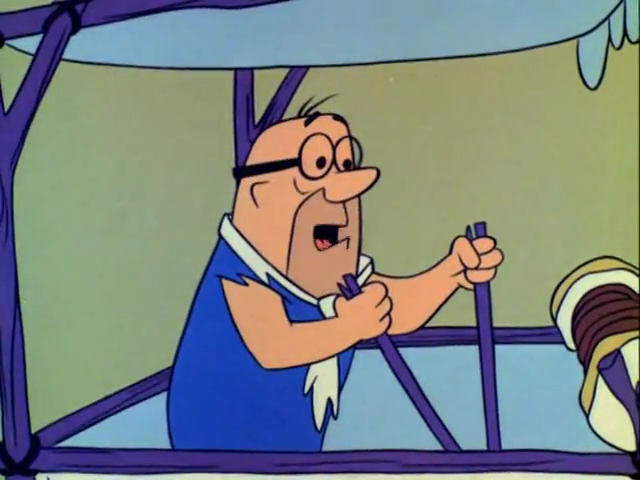

In [1339]:
rown = random.randint(0, suspect_worker_df.shape[0])
still_to_inspect = suspect_worker_df.iloc[rown]['still_id']
print(suspect_worker_df.iloc[rown]['characters'])
display_image(still_to_inspect)

In [1302]:
all_empty_suspect_df = char_df[char_df['w_id'].isin(to_reject_empty)]
all_total_suspect_df = char_df[char_df['w_id'].isin(to_reject_all)]

In [1314]:
len(all_total_suspect_df)

7420

In [1303]:
all_empty_suspect_df_e_only = all_empty_suspect_df[all_empty_suspect_df['characters'].apply(lambda x: 'empty frame' in x)]

In [1313]:
len(all_empty_suspect_df_e_only)

2034

In [1304]:
assignemnts_to_reject = set(all_empty_suspect_df_e_only['asgnmt_id'].tolist()).union(set(all_total_suspect_df['asgnmt_id'].tolist()))

In [1307]:
len(assignemnts_to_reject)

9454

In [1308]:
to_reject_empty

{'A15DOG6AXQ7LGY',
 'A1IOMFFEKCWOIT',
 'A1RULXRXR2XF6M',
 'A2L97S8Z5FZK5N',
 'A2NJTYYY37DNO',
 'A3R6KO03P9QLNO',
 'A3UPV16IECELHV'}

In [1340]:
pickle_this(to_reject_empty.union(to_reject_all), 'workers_to_ban_prod_1_4.pkl')

In [1341]:
pickle_this(assignemnts_to_reject, 'assignments_to_reject_prod_1_4.pkl')

## pd

In [64]:
def make_standard_fig(fig_plt, fig_labels=None, outfile='latest_fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
#     plt.savefig(outfile, bbox_inches='tight')

In [ ]:
def all_main(char_set, main_chars=main_characters):
    return not bool(char_set.difference(main_chars))

def all_minor(char_set, main_chars=main_characters):
    return not bool(char_set.difference(main_chars))

In [125]:
char_df = pd.DataFrame(characters_present)
char_df['aid'] = char_df['still_id'].apply(lambda x: x.rsplit('_', 1)[0])
char_df['all_main'] = char_df['characters'].apply(lambda x: all_main(x))
char_df['no_main'] = char_df['characters'].apply(lambda x: no_main(x))
char_df['n_chars'] = char_df['characters'].apply(lambda x: len(x))
all_chars = [c for char_list in char_df['characters'].apply(lambda x: list(x)).tolist() for c in char_list]

In [126]:
char_ser = pd.Series(all_chars)

In [127]:
char_counts = char_ser.value_counts()

In [129]:
# char_hist = char_counts[(char_counts > 20) &  (char_counts < 100)].plot(kind="bar", log=True)
# plt.xticks(rotation=80) 
# make_standard_fig(char_hist, fig_labels)

In [130]:
# sample_row = char_df[char_df['w_id'] == 'A3R6KO03P9QLNO']
# sample_row =  sample_row[sample_row['characters'].apply(lambda x: bool(x.intersection({'empty frame'})))].iloc[random.randint(0, 100)]
# print(sample_row['characters'])
# display_image(sample_row['still_id'])

In [131]:
grouped_by_still = char_df.groupby('still_id')
agg_df = grouped_by_still.aggregate(len)

agged_on_mode = grouped_by_still.agg(lambda x: st.mode(x))

In [175]:
consensus_results_df = agged_on_mode.reset_index()

consensus_results_df['count_mode'] = consensus_results_df['n_chars'].apply(lambda x: x[1][0])
consensus_results_df['mode_count'] = consensus_results_df['characters'].apply(lambda x: x[1][0])

consensus_results_df['all_agree'] = consensus_results_df['count_mode'] == 3
consensus_results_df['two_agree'] = consensus_results_df['count_mode'] == 2

char_count_df = consensus_results_df[consensus_results_df['count_mode'] == 3]

agree_all = consensus_results_df[consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 3]
two_agree = consensus_results_df[consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 2]

agree_all_main = agree_all[agree_all['all_main'].apply(lambda x: x[0][0]) == True]
agree_no_main = agree_all[agree_all['all_main'].apply(lambda x: x[0][0]) == False]

agree_two_main = two_agree[two_agree['all_main'].apply(lambda x: x[0][0]) == True]
agree_two_not_all = two_agree[two_agree['all_main'].apply(lambda x: x[0][0]) == False]

# not_main =set(consensus_results_df[~agree_all_main]['still_id'].tolist())
# not_main_df = char_df[char_df['still_id'].isin(not_main)]


# all_agree = consensus_results_df[agree_all_main][consensus_results_df[agree_all_main]['all_agree']]
# disagree = consensus_results_df[agree_all_main][~consensus_results_df[agree_all_main]['all_agree']]

# all_agree_set = set(all_agree['still_id'].tolist())

# count_all_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 3]['still_id'].tolist())
# count_two_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 2]['still_id'].tolist())
# count_none_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 1]['still_id'].tolist())

# conflict_images = set(disagree['still_id'].tolist())

# conflict_df = char_df[char_df['still_id'].isin(conflict_images)]

In [326]:
agree_no_main

,still_id,asgnmt_id,characters,h_id,w_id,aid,all_main,no_main,n_chars,count_mode,mode_count,all_agree,two_agree
72,s_01_e_01_shot_026517_026591_40.png,"([30BXRYBRP5X5NX9DUWPFB4PB0N3HWD], [1])","([{woman dressed as viking}], [1])","([3BPP3MA3TDKA598IAF55S6GXOBWELE], [3])","([A2SNX8GORIS8FN], [1])","([s_01_e_01_shot_026517_026591], [3])","([False], [3])","([True], [3])","([1], [3])",3,1,True,False
181,s_01_e_02_shot_023364_023438_40.png,"([31JLPPHS2VUIOGTCOP93QGBFEDRO30], [1])","([{drummer, man in purple}], [1])","([3AQN9REUTGGPD21HXZJBGW08XDHDYS], [3])","([A13U6AYPZ6QENK], [1])","([s_01_e_02_shot_023364_023438], [3])","([False], [3])","([True], [3])","([2], [3])",3,1,True,False
187,s_01_e_02_shot_028039_028113_40.png,"([30BXRYBRP5X5NX9DUWPFB4PB0NQHW0], [1])","([{girl with blond ponytail and glasses, girl ...","([3VEI3XUCZSXP5YSLODIC8UO08AKPRX], [3])","([A1PYB1RQW0XD3E], [1])","([s_01_e_02_shot_028039_028113], [3])","([False], [3])","([True], [3])","([2], [2])",2,1,False,True
197,s_01_e_02_shot_031269_031343_40.png,"([3JAOYWH7VJ4WXXFVS6ULPCA7J28L9D], [1])","([{blonde woman with black glasses, man wearin...","([3YGE63DIN9XRPD5N6MDSGSV9SHN0W4], [3])","([A2VI8XH6A1PB27], [1])","([s_01_e_02_shot_031269_031343], [3])","([False], [3])","([True], [3])","([3], [2])",2,1,False,True
199,s_01_e_02_shot_031865_031939_40.png,"([35L9RVQFCPISVTK8ZWAETG4EF6ZHUJ], [1])","([{spectator girl yellow hair, spectator girl ...","([3HY86PZXPZIXF24EH5NM8R7JQ5ME13], [3])","([A11DV053R2UV8J], [1])","([s_01_e_02_shot_031865_031939], [3])","([False], [3])","([True], [3])","([2], [2])",2,1,False,True
267,s_01_e_03_shot_026682_026756_40.png,"([320DUZ38G8M5HHE33ROI1EJ2JQ8JGA], [1])","([{man with cigar talking on the phone}], [1])","([3HRWUH63QV20XQIABRSH14E9GCQN5F], [3])","([A2VIO4KLFL3BUH], [1])","([s_01_e_03_shot_026682_026756], [3])","([False], [3])","([True], [3])","([1], [3])",3,1,True,False
281,s_01_e_03_shot_030724_030798_40.png,"([3570Y55XZQJVC692PRPLB1YQWUSGYC], [1])","([{bald man with brown clothes}], [1])","([38G0E1M85N5UQAHYEJMGJX021WMUVM], [3])","([A3TWYQENN82FJI], [1])","([s_01_e_03_shot_030724_030798], [3])","([False], [3])","([True], [3])","([1], [3])",3,1,True,False
284,s_01_e_03_shot_031399_031473_40.png,"([3IAEQB9FMFKOBH4B806PKJAD8V2DWS], [1])","([{police}], [1])","([3R5LWXWHR183PHLYUTYH33WW80JGXH], [3])","([A1IOMFFEKCWOIT], [1])","([s_01_e_03_shot_031399_031473], [3])","([False], [3])","([True], [3])","([1], [2])",2,1,False,True
287,s_01_e_03_shot_032428_032502_40.png,"([3P529IW9KZL5Y768VSUDZ8WIMYMFLE], [1])",([{police officer with orange mustache and bil...,"([3U74KRR67NL2IST0CNAF4KKNWF0NTU], [3])","([A8HQT8FK59SVO], [1])","([s_01_e_03_shot_032428_032502], [3])","([False], [3])","([True], [3])","([1], [3])",3,1,True,False
332,s_01_e_04_shot_012375_012449_40.png,"([3A4NIXBJ77ZB4HYPHFYQUYGRJZFLM8], [1])","([{shocking man}], [2])","([329E6HTMSX2WB5A30VC8UFZL8LL3KR], [3])","([A2BOXK0KVXGKPU], [1])","([s_01_e_04_shot_012375_012449], [3])","([False], [3])","([True], [3])","([1], [3])",3,2,True,False


In [318]:
char_df[char_df['aid'] == 's_06_e_11_shot_042392_042466']

,asgnmt_id,characters,h_id,still_id,w_id,aid,all_main,no_main,n_chars
966,3TDXMTX3CCU7PD5R9WUWDMRDCYQI67,{empty frame},3YKP7CX6G3FDJL7WWU258TSBQUE7BY,s_06_e_11_shot_042392_042466_40.png,A3UPV16IECELHV,s_06_e_11_shot_042392_042466,True,False,1
967,3ZWFC4W1UV7G151L0CR9LK5HSTDFRC,{empty frame},3YKP7CX6G3FDJL7WWU258TSBQUE7BY,s_06_e_11_shot_042392_042466_40.png,A1RULXRXR2XF6M,s_06_e_11_shot_042392_042466,True,False,1
968,3Z3ZLGNNSJUL9S6S3217FL6FTH6Q3D,{wilma},3YKP7CX6G3FDJL7WWU258TSBQUE7BY,s_06_e_11_shot_042392_042466_40.png,A1IFX10A8ZRFUV,s_06_e_11_shot_042392_042466,True,False,1


In [317]:
consensus_results_df

,still_id,asgnmt_id,characters,h_id,w_id,aid,all_main,no_main,n_chars,count_mode,mode_count,all_agree,two_agree
0,s_01_e_01_shot_000099_000173_40.png,"([3DYGAII7PM8SGHBF10YESO9GYCEQP3], [1])","([{fred, barney}], [3])","([3D17ECOUOFVU54OHSL6QP03MZGY131], [3])","([A2R65L9397776L], [1])","([s_01_e_01_shot_000099_000173], [3])","([True], [3])","([False], [3])","([2], [3])",3,3,True,False
1,s_01_e_01_shot_001584_001658_40.png,"([3L6L49WXW1XHY26YJOINRF3UBJI45Y], [1])","([{fred}], [2])","([3QGHA0EA0K0S908X42AH09RSJK9WB9], [3])","([A1H5Y0IB7L7CPZ], [1])","([s_01_e_01_shot_001584_001658], [3])","([True], [3])","([False], [3])","([1], [2])",2,2,False,True
2,s_01_e_01_shot_001694_001768_40.png,"([34Z02EIMITD2KGZN1JDJISJVA98T0G], [1])","([{dino}], [3])","([3XD2A6FGFOUGEQCRMDMKCETHP739SQ], [3])","([A1KV52WJ5U7W5E], [1])","([s_01_e_01_shot_001694_001768], [3])","([True], [3])","([False], [3])","([1], [3])",3,3,True,False
3,s_01_e_01_shot_001936_002010_40.png,"([333U7HK6IAF25X4C11NAVTG56ZMDJQ], [1])","([{empty frame}], [3])","([31MCUE39BLMR9JEKA4RTWN7S15HG3G], [3])","([A2CXEAMWU2SFV3], [1])","([s_01_e_01_shot_001936_002010], [3])","([True], [3])","([False], [3])","([1], [3])",3,3,True,False
4,s_01_e_01_shot_002161_002235_40.png,"([36V4Q8R5ZL0MVEE29K6MBKFLT7LQMP], [1])","([{fred}], [3])","([3GL25Y6844U3HRHK5WWCG8GT4LRMXP], [3])","([A14JSDBSM2XQCO], [1])","([s_01_e_01_shot_002161_002235], [3])","([True], [3])","([False], [3])","([1], [3])",3,3,True,False
5,s_01_e_01_shot_002288_002362_40.png,"([354GIDR5ZC61472W3HP9YHHQDYB00B], [1])","([{fred}], [3])","([37J05LC5AYJZID6IBZI869LKK94JD0], [3])","([A2Y7ZBJE4MPA1W], [1])","([s_01_e_01_shot_002288_002362], [3])","([True], [3])","([False], [3])","([1], [3])",3,3,True,False
6,s_01_e_01_shot_002640_002714_40.png,"([3P1L2B7AD2PZ4KJ1UVD3M25WE09LO4], [1])","([{bamm bamm}], [2])","([3ECKRY5B1RW6Q3R8LZM5L0PNVCXIZU], [3])","([A2SD47UV25XSGN], [1])","([s_01_e_01_shot_002640_002714], [3])","([True], [3])","([False], [3])","([1], [3])",3,2,True,False
7,s_01_e_01_shot_003432_003506_40.png,"([30X31N5D64QX6TKQ4L5MXTZMHERASO], [1])","([{barney}], [3])","([31KPKEKW4BDZ1A7CBVHWTEIOIG3B0X], [3])","([A2MCOIIGEN02W9], [1])","([s_01_e_01_shot_003432_003506], [3])","([True], [3])","([False], [3])","([1], [3])",3,3,True,False
8,s_01_e_01_shot_003663_003737_40.png,"([3A4TN5196LIW9Z38D5PEZAI884FHCS], [1])","([{fred}], [3])","([3ICOHX7ENDBX8DJWLMJMUMO9LC0E0I], [3])","([A32QBXDPHHSTOD], [1])","([s_01_e_01_shot_003663_003737], [3])","([True], [3])","([False], [3])","([1], [3])",3,3,True,False
9,s_01_e_01_shot_003762_003836_40.png,"([3Q8GYXHFEQ2KT6JDC3O5ADFI3YKC58], [1])","([{barney}], [3])","([3WGCNLZJKG8SNWQELAC229PYQTOD1C], [3])","([A2CXEAMWU2SFV3], [1])","([s_01_e_01_shot_003762_003836], [3])","([True], [3])","([False], [3])","([1], [3])",3,3,True,False


In [147]:
# consensus_count_df = consensus_results_df[consensus_results_df['count_mode'] > 1]

In [151]:
# all_main_chars = consensus_results_df[agree_all_main]
# not_all_main_chars = consensus_results_df[~agree_all_main]

In [212]:
perfect_con = agree_all_main[agree_all_main['mode_count'] == 3]
con_2_of_3 = agree_all_main[agree_all_main['mode_count'] == 2]
no_con_main = agree_all_main[agree_all_main['mode_count'] == 1]

In [213]:
all_main_3 = perfect_con.shape[0]
all_main_2of3 = con_2_of_3.shape[0] 
all_main_no_con = no_con_main.shape[0]

In [183]:
main_2_of_3 = agree_two_main.shape[0]

In [184]:
not_main_2_of_3 = agree_two_not_all.shape[0]

In [273]:
agree_two_main_subagree = agree_two_main[agree_two_main['characters'].apply(lambda x: x[1][0]) == 2]
agree_two_main_subdisagree = agree_two_main[agree_two_main['characters'].apply(lambda x: x[1][0]) == 1]

In [278]:
amsa = agree_two_main_subagree.shape[0]
amsda = agree_two_main_subdisagree.shape[0]

In [277]:
bin_df.sum().sum()

19960

In [218]:
all_agree_no_main = agree_no_main.shape[0]

In [280]:
bin_df = pd.DataFrame({'agree all main': [all_main_3, all_main_2of3, all_main_no_con, 0, 0, 0, 0], 'not all main': [0, 0, 0, all_agree_no_main, amsa, amsda, not_main_2_of_3]}).T

In [288]:
bin_df.columns = ['3/o3 agree on label', '2/3 agree on label', 'no-consensus (most suspicious bucket)', '3/3 agree no main characters', '2/3 agree main characters-agree on label', '2/3 agree main characters-disagree on label', '2/3 agree not main characters']

In [282]:
fig_labels = {
    'fig_title': 'Character string consensus', 
    'x_label': 'Are all labels main characters?',
    'y_label': '# Videos'
}

In [293]:
def get_vid_ids(charcon_df):
    return set(charcon_df['aid'].apply(lambda x: x[0][0]).tolist())

In [310]:
label_consensus_bins = {
        '3of3 agree on label': get_vid_ids(perfect_con),
        '2of3 agree on label': get_vid_ids(con_2_of_3),
        'no-consensus (most suspicious bucket)': get_vid_ids(no_con_main),
        '3of3 agree no main characters': get_vid_ids(agree_no_main),
        '2of3 agree main characters-agree on label': get_vid_ids(agree_two_main_subagree),
        '2of3 agree main characters-disagree on label': get_vid_ids(agree_two_main_subdisagree),
        '2of3 agree not main characters': get_vid_ids(agree_two_not_all)
    }

In [327]:
pass_bins = ['3of3 agree on label',  '2of3 agree on label', '3of3 agree no main characters']

In [338]:
videos_to_pass = [list(vid) for bn, vid in label_consensus_bins.items() if bn in pass_bins]

In [340]:
videos_to_pass = set([vid for sublist in videos_to_pass for vid in sublist])

In [342]:
len(videos_to_pass)

13679

In [344]:
pickle_this( videos_to_pass, 'vids_to_pass_9_8.pkl')

In [335]:
len(videos_to_pass)

16

In [311]:
all_vid_ids = []
for vbin, vids in label_consensus_bins.items():
    all_vid_ids.extend(vids)

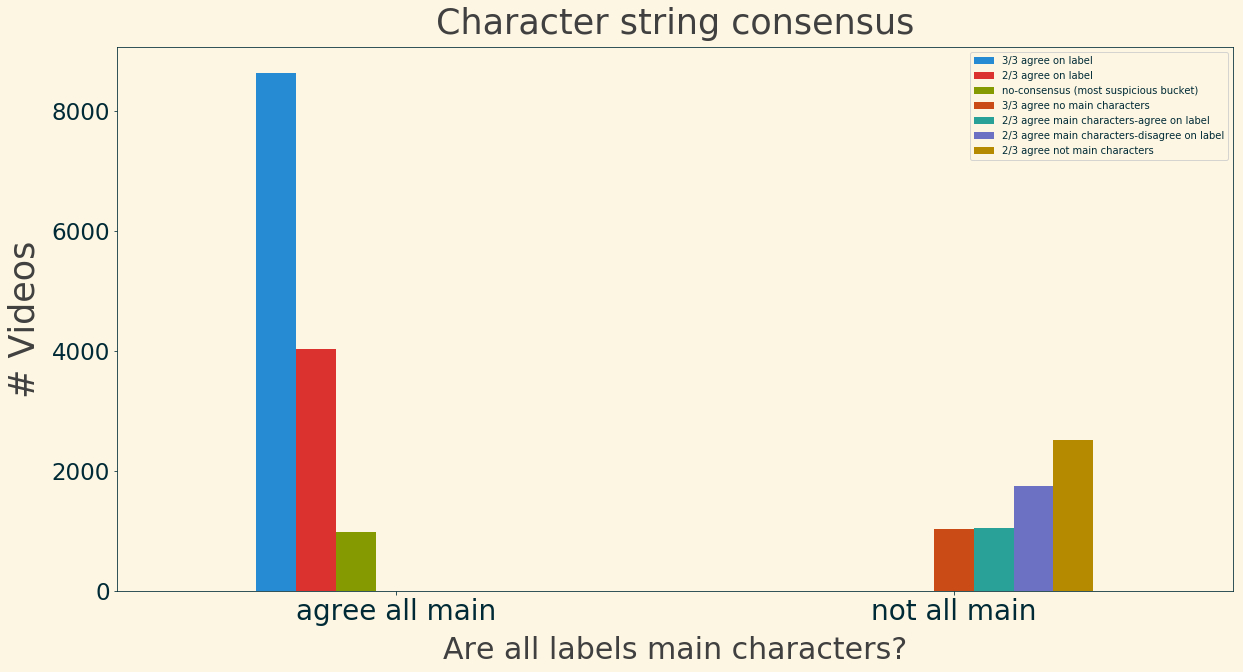

In [283]:
string_con_plot = bin_df.plot.bar()
plt.xticks(rotation=0) 
make_standard_fig(string_con_plot, fig_labels)

In [101]:
three_agree = char_count_df[char_count_df['mode_count'] == 3]

In [103]:
three_agree.shape

(8641, 12)

In [80]:
fig_labels = {
    'fig_title': '# Characters in Frame', 
    'x_label': '# Characters',
    'y_label': '# Frames'
}

In [82]:
# _ = consensus_count_df[consensus_count_df['frame_char_count'] < 11]['frame_char_count'].hist(bins=8)
# # plt.xticks(rotation=80) 
# make_standard_fig(char_hist, fig_labels)

In [ ]:
char_df['characters'] = char_df['characters'].apply(lambda x: list(x))
grouped_by_worker = char_df.groupby('w_id')

In [83]:
# w_agged = grouped_by_worker['characters'].sum()

# del_hit = 'A1D9FOXZ0UT0L2'

# w_agged = w_agged[~w_agged.index.str.contains(del_hit)]

# # unique_chars = w_agged.apply(lambda x: len(x) /len(set(x)))

# empty_fraction = w_agged.apply(lambda x: len([char for char in x if char == 'empty frame'])/ len(x))

# empty_workers = empty_fraction[empty_fraction.sort_values(ascending=False) > 0.2]

In [647]:
all_chars_agged = w_agged.apply(lambda x: len(x))

In [84]:
# prolific_workers = all_chars_agged[all_chars_agged > 100]

# suspect_workers = set(prolific_workers.index).intersection(set(empty_workers.index))

## empty_workers

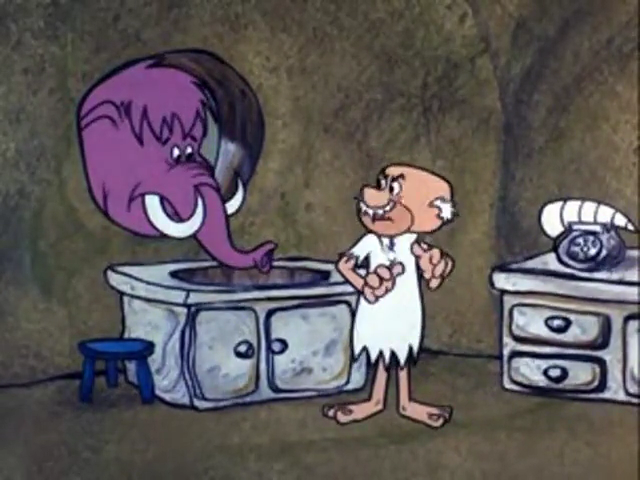

In [487]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

image_url = s3_base_path + 's_04_e_05_shot_015403_015477_40.png'
Image.open(requests.get(image_url, stream=True).raw)

In [799]:
char_df['characters'].apply(lambda x: [c for c in x if c != 'empty frame']).apply(lambda x: len(x)).mean()

1.4475733672036901

In [800]:
1632 * (1 + 1.38)

3884.16

In [305]:
# char_df[char_df['w_id'].isin(suspect_workers)][400:]

In [801]:
mono_worker = unique_chars[unique_chars < 5]

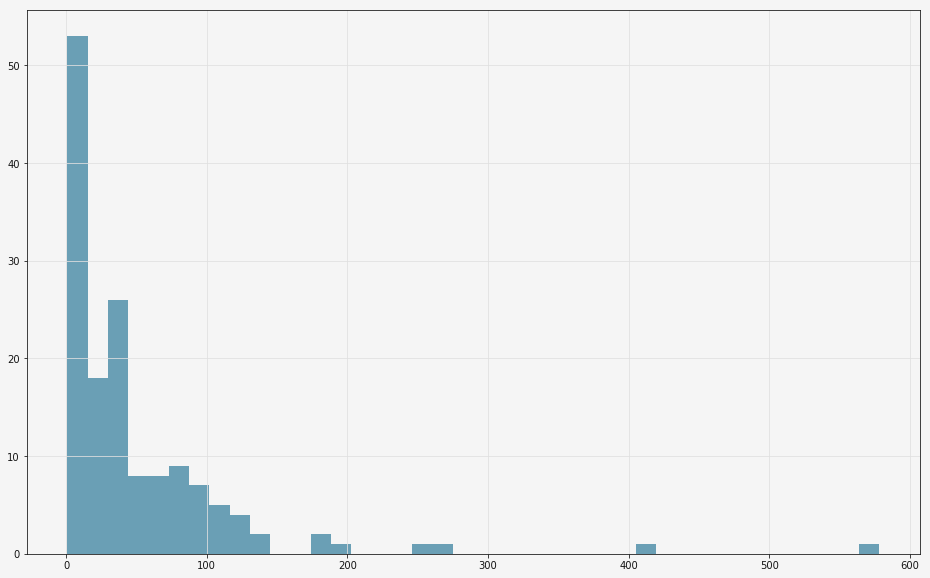

In [211]:
_ = all_chars.hist(bins=40)

In [154]:
consensus_results_df[consensus_results_df['two_agree']]

,still_id,characters,h_id,w_id,aid,all_main,n_chars,count_mode,mode_count,all_agree,two_agree
34,s_01_e_06_shot_021230_021304_40.png,"([{man with scarf and cap, man with blue glass...","([3NQUW096N78TADH124PJ0SFMXC29LH], [3])","([A1CUIN1FSZCM50], [1])","([s_01_e_06_shot_021230_021304], [3])","([False], [2])","([2], [2])",2,1,False,True
35,s_01_e_06_shot_023265_023339_40.png,"([{fred}], [1])","([3D17ECOUOFVU54OHSL6QP03MZEM31N], [3])","([A11NUW5OVADGYU], [1])","([s_01_e_06_shot_023265_023339], [3])","([False], [2])","([2], [2])",2,1,False,True
41,s_01_e_07_shot_007742_007816_40.png,"([{barney}], [1])","([307L9TDWJZSXJBV6X84OM7GP2FS3NW], [3])","([A1J8Y204VZNWQW], [1])","([s_01_e_07_shot_007742_007816], [3])","([False], [2])","([1], [2])",2,1,False,True
52,s_01_e_13_shot_014034_014108_40.png,"([{fred}], [1])","([3MGHRFQY2MPVEI0NLNVG1PGP3NBY0L], [3])","([A11NUW5OVADGYU], [1])","([s_01_e_13_shot_014034_014108], [3])","([True], [3])","([1], [2])",2,1,False,True
55,s_01_e_13_shot_028290_028364_40.png,"([{betty, wilma}], [1])","([37NXA7GVSU6R7KU455UFSA4JO4KVLI], [3])","([A26699AEVYMM7N], [1])","([s_01_e_13_shot_028290_028364], [3])","([False], [2])","([3], [2])",2,1,False,True
60,s_01_e_14_shot_014144_014218_40.png,"([{fred, wilma}], [2])","([3CMV9YRYP41IGPUAOGGWPMTPTHCJLK], [3])","([A1OFOVU6TCQ2K3], [1])","([s_01_e_14_shot_014144_014218], [3])","([True], [3])","([2], [2])",2,2,False,True
62,s_01_e_14_shot_024354_024428_40.png,"([{fred}], [1])","([32CAVSKPCFPE4Y10752RC9TMCR5U1L], [2])","([A2QG1N2LFV0VXW], [1])","([s_01_e_14_shot_024354_024428], [2])","([True], [2])","([1], [2])",2,1,False,True
65,s_01_e_16_shot_006532_006606_40.png,"([{wilma}], [2])","([3MQY1YVHS4K6XKAQQILAC2B3FCD2BU], [3])","([A1CXAIALV3056P], [1])","([s_01_e_16_shot_006532_006606], [3])","([True], [2])","([1], [2])",2,2,False,True
66,s_01_e_16_shot_013486_013560_40.png,"([{fred, barney}], [2])","([3XBYQ44Z6Q4S5M2E4O1203XEPQ8TWT], [3])","([A1CXAIALV3056P], [1])","([s_01_e_16_shot_013486_013560], [3])","([True], [3])","([2], [2])",2,2,False,True
70,s_01_e_16_shot_025041_025115_40.png,"([{fred, barney}], [2])","([3RWO3EJELI91CTT4QJ3X236N4AE1PX], [2])","([A1HA4T6P2CM2WV], [1])","([s_01_e_16_shot_025041_025115], [2])","([True], [2])","([2], [2])",2,2,False,True


In [138]:
600 * 3 * 3

5400

In [139]:
char_df.shape[0] * 0.05

243.4

In [816]:
char_counts = pd.Series(all_chars).value_counts()

In [821]:
char_counts[char_counts < 35].sum()

13206

In [142]:
char_counts[char_counts < 16].sum()

932

In [143]:
char_df['empty'] = ~char_df['characters'].apply(lambda x:bool(x.difference(set(empty_characters))))

In [144]:
char_df['nonmain_characters'] = char_df['characters'].apply(lambda x: len(x.difference(set(main_characters))))

In [145]:
grouped_by_aid = char_df.groupby('aid')

In [146]:
grouped_by_aid.agg(max)['nonmain_characters'].sum()

708

In [147]:
grouped_by_aid.agg(max).shape

(1632, 8)

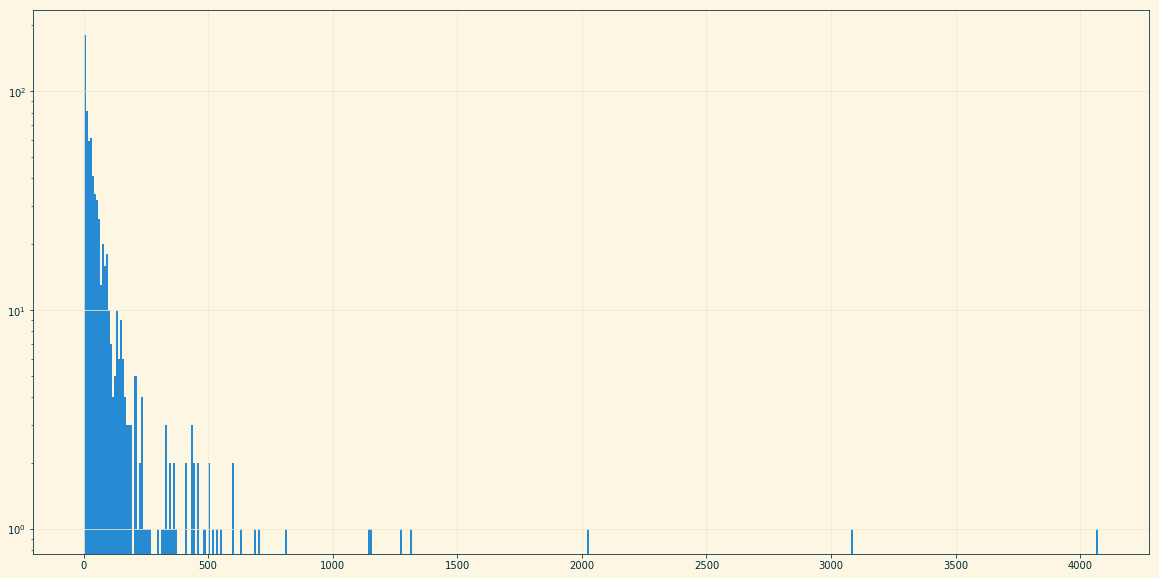

In [1151]:
_ = char_df['w_id'].value_counts().hist(bins=500, log=True)

In [148]:
grouped_by_aid.agg(max)['nonmain_characters'].sum() * 3 * 3  * 0.02

127.44

In [150]:
# grouped_by_aid.agg(max)[grouped_by_aid.agg(min)['empty'] == True]

In [151]:
grouped_by_aid.agg(min)['empty'].sum()

73

In [152]:
grouped_by_aid.agg(max).shape

(1632, 8)

# create subtask data

In [10]:
from amt_utils.bboxes import create_subtask_data
from amt_utils.bboxes import cluster_from_nms

In [12]:
# pickle_this(annotations_by_frame, 'batch_1_4_annotations_by_frame')

In [36]:
len(annotations_by_frame)

20000

In [24]:
st_stills = unpickle_this('subtask_still.pkl')

In [48]:
st_still_1 = {k:v for k,v in st_stills.items() if v > 0}

In [50]:
pickle_this(st_still_1, 'prod_1_4_subtask.pkl')

In [49]:
len(st_still_1)

18154

In [45]:
quality_filtered_subtasks[0]

's_01_e_01_shot_000099_000173'

In [34]:
test_sub_anno = list(annotations_by_frame.items())[:3]

In [18]:
gen_subtask(*list(annotations_by_frame.items())[0])

's_01_e_01_shot_000099_000173'

In [23]:
def gen_subtask(aid, animation_annos):
    return aid

In [1802]:
processed_stage_1_a = {}
for aid, animation_annos in tqdm(list(annotations_by_frame.items())):
    try:
        consensus_boxes, labels = cluster_and_label(animation_annos, cluster_from_nms)
        label_choices = select_labels(consensus_boxes, labels)
        processed_stage_1_a[aid] = {'con_boxes': consensus_boxes, 'all_boxes': labels}
    except:
        print(aid)

 19%|█▉        | 3791/20000 [00:02<00:08, 1939.17it/s]

s_02_e_04_shot_023193_023267


100%|██████████| 20000/20000 [00:10<00:00, 1830.04it/s]


In [1803]:
pickle_this(processed_stage_1_a, 'processed_stage1_boxes_all_boxes.pkl')

In [1805]:
processed_stage_1_a['s_01_e_03_shot_036331_036405']

{'all_boxes': [{'area': 57534,
   'box': array([210, 142, 433, 400]),
   'duplicate_of': 2,
   'idx': 0,
   'label': 'barney'},
  {'area': 45790,
   'box': array([237, 150, 427, 391]),
   'duplicate_of': 2,
   'idx': 1,
   'label': 'man with head in bucket'},
  {'area': 44781,
   'box': array([228, 135, 405, 388]),
   'chosen_labels': 'guy with head in bucket',
   'idx': 2,
   'label': 'guy with head in bucket',
   'possible_labels': {'barney',
    'guy with head in bucket',
    'man with head in bucket'},
   'votes': 3}],
 'con_boxes': [{'area': 44781,
   'box': array([228, 135, 405, 388]),
   'chosen_labels': 'guy with head in bucket',
   'idx': 2,
   'label': 'guy with head in bucket',
   'possible_labels': {'barney',
    'guy with head in bucket',
    'man with head in bucket'},
   'votes': 3}]}

In [194]:
len(processed_stage_1_a)

19999

In [19]:
subtask_stills = {}
for aid, animation_annos in tqdm(list(annotations_by_frame.items())):
    try:
        two_frame_img, char_crops = create_subtask_data(animation_annos, cluster_from_nms)
        if char_crops:
#             two_frame_img.save('./subtask_data/frames/' + aid + '_taskb.png')
            n_chars = len([charn for charn, char_image in enumerate(char_crops)])
            subtask_stills[aid + '_taskb.png'] = n_chars
    except:
        print(aid)

100%|██████████| 1632/1632 [01:27<00:00, 18.64it/s]


In [23]:
pickle_this(subtask_stills, 'subtask_stills_8.pkl')

In [197]:
list(subtask_stills.values())[0]

NameError: name 'subtask_stills' is not defined

In [20]:
# subtask_stills = {}
# for aid, animation_annos in tqdm(list(annotations_by_frame.items())):
#     try:
#         two_frame_img, char_crops = create_subtask_data(animation_annos, cluster_from_nms)
#         if char_crops:
#             two_frame_img.save('./subtask_data/frames/' + aid + '_taskb.png')
#             n_chars = len([char_image.save('./subtask_data/char_crops/' + aid + '_char_' + str(charn) +'_taskb.png') for charn, char_image in enumerate(char_crops)])
#             subtask_stills[aid + '_taskb.png'] = n_chars
#     except:
#         print(aid)

In [20]:
# pickle_this(subtask_stills, 'subtask_stills_to_anno_prod_1_4.pkl')

In [202]:
st_rev = unpickle_this('./pickeled_results/prod_1_4_subtask.pkl')

FileNotFoundError: [Errno 2] No such file or directory: './pickeled_results/s_02_e_07_shot_010402_010476.pkl'

In [207]:
st_rev['s_02_e_07_shot_010402_010476_taskb.png']

4

# bounding box clustering

In [12]:
len(annotations_by_frame)

20000

In [319]:
dataset_v0p1 = unpickle_this('../../build_dataset/dataset_v0p1.pkl')

In [320]:
dataset_v_01_ids = set([vid['globalID'] for vid in dataset_v0p1])

In [322]:
len(dataset_v_01_ids)

10893

In [226]:
st3_df_image_ids = list(set(pd.read_csv('../stage_3/stage_3_beta_sample_ids.csv', header=None)[0].tolist()))

In [227]:
st3_anno_by_frame = {k: v for k, v in annotations_by_frame.items() if k in st3_df_image_ids}

In [285]:
len(annotations_by_frame)

20000

In [15]:
rev_dir = 'review_results'
img_dir = 'review_frames'

In [ ]:
label_consensus_bins

In [324]:
rev_dir = 'review_results'
img_dir = 'review_frames'


for select_bin in sorted(list(label_consensus_bins.keys())):
    review_seq = {}
    error_frames = []
    print(select_bin)
    bin_annotations = {k: v for k, v in annotations_by_frame.items() if k in label_consensus_bins[select_bin] if k in dataset_v_01_ids}
    for aid, animation_annos in tqdm(random.sample(list(bin_annotations.items()), min(len(bin_annotations), 50))):
    # for aid, animation_annos in tqdm(list(st3_anno_by_frame.items())):
        single_frame_image, consensus_boxes, labels = draw_image_and_labels(animation_annos, cluster_from_nms)
        img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
        s_frame_img = Image.fromarray(single_frame_image)
        s_frame_img.save(img_path)
        label_choices = select_labels(consensus_boxes, labels)
        avg_votes = np.mean([box['votes'] for box in consensus_boxes])
        avg_votes = np.nan_to_num(avg_votes)
        possible_labels = [c['possible_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
        chosen_labels = [c['chosen_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
        review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}

    #     except:
    #         error_frames.append(aid)
    html_file_name = 'bboxes_' + select_bin + '.html'
    html_file_name = html_file_name.replace(' ', '_')
    rev_page = generate_review_page(review_seq, html_file_name)

  0%|          | 0/50 [00:00<?, ?it/s]

2of3 agree main characters-agree on label


  2%|▏         | 1/50 [00:00<00:08,  5.50it/s]

2of3 agree main characters-disagree on label


  2%|▏         | 1/50 [00:00<00:08,  5.63it/s]

2of3 agree not main characters


  2%|▏         | 1/50 [00:00<00:08,  5.50it/s]

2of3 agree on label


  2%|▏         | 1/50 [00:00<00:07,  6.70it/s]

3of3 agree no main characters


  0%|          | 0/50 [00:00<?, ?it/s]

3of3 agree on label


  2%|▏         | 1/50 [00:00<00:06,  7.44it/s]

no-consensus (most suspicious bucket)


100%|██████████| 50/50 [00:10<00:00,  4.99it/s]


'/Users/schwenk/wrk/animation_gan/turk_annotation_task/stage_1'

In [1788]:
annotations_by_frame['s_02_e_29_shot_014705_014779']

[{'asgmt_id': '3X0H8UUIT2OUD6NT5Q1EFIWD9V8WSV',
  'characterBoxes': '[{"left":168,"top":191,"width":140,"height":238,"label":"barney"},{"left":394,"top":92,"width":148,"height":335,"label":"man with blue hair"},{"left":230,"top":56,"width":133,"height":168,"label":"woman with hat"},{"left":98,"top":73,"width":110,"height":150,"label":"man in green shirt"}]',
  'h_id': '3SZYX62S5H0BU5QNVKBS57SJGX775A',
  'stillID': 's_02_e_29_shot_014705_014779_40.png',
  'worker_id': 'A2SLEMDA17XTZ1'},
 {'asgmt_id': '3ZSANO2JCG7S2K1YF1REBUADESJFSH',
  'characterBoxes': '[{"left":137,"top":85,"width":70,"height":122,"label":"empty frame"},{"left":247,"top":79,"width":107,"height":145,"label":"empty frame"},{"left":407,"top":79,"width":125,"height":349,"label":"empty frame"},{"left":175,"top":197,"width":135,"height":228,"label":"barney"}]',
  'h_id': '3SZYX62S5H0BU5QNVKBS57SJGX775A',
  'stillID': 's_02_e_29_shot_014705_014779_40.png',
  'worker_id': 'A3UPV16IECELHV'},
 {'asgmt_id': '3PWWM24LHTYQI6ADD862

In [39]:
list(review_seq.items())[0]

('s_01_e_01_shot_000099_000173',
 {'chosen_labels': ['fred', 'barney'],
  'possible_labels': [{'fred'}, {'barney'}],
  'votes': 3.0})

In [44]:
quality_filtered_subtasks = [aid for aid, labels in review_seq.items() if len(labels['chosen_labels']) > 0]
quality_filtered_subtasks = [aid for aid, labels in review_seq.items() if labels['votes'] > 1]

In [107]:
filtered_out_single_vote = [aid for aid, labels in review_seq.items() if labels['votes'] < 1]

In [16]:
consensus_char_labels = [anim['chosen_labels'] for anim in review_seq.values()]
consensus_labels = [item for sublist in consensus_char_labels for item in sublist]

In [17]:
len(consensus_labels)

29097

In [46]:
char_ser = pd.Series(consensus_labels).value_counts()

In [60]:
fig_labels = {
    'fig_title': 'Minor Character Frequencies-log axis', 
    'x_label': '# Occurrences',
    'y_label': '# Characters'
}

# _  = char_ser[char_ser < 81].hist(bins=80, log=True)
# make_standard_fig(char_hist, fig_labels)

In [18]:
con_labels_counts = pd.Series(consensus_labels).value_counts()

In [153]:
fig_labels = {
    'fig_title': 'Consensus Character Frequency- Somewhat Frequent', 
    'x_label': 'Character',
    'y_label': '# Occurrences'
}

# char_hist = con_labels_counts[(con_labels_counts > 3) &  (con_labels_counts < 10)].plot(kind="bar", log=False)
# # char_hist = con_labels_counts.plot(kind="bar")
# plt.xticks(rotation=70) 
# make_standard_fig(char_hist, fig_labels)

In [1798]:
pickle_this(vid_bins, 'vid_bin_assignments.pkl')

In [499]:
# vid_bins['bin_11_vids']

['s_01_e_01_shot_009731_009805',
 's_01_e_01_shot_011638_011712',
 's_01_e_01_shot_014586_014660',
 's_01_e_01_shot_017136_017210',
 's_01_e_01_shot_018227_018301',
 's_01_e_01_shot_020779_020853',
 's_01_e_01_shot_021791_021865',
 's_01_e_01_shot_022867_022941',
 's_01_e_01_shot_028279_028353',
 's_01_e_01_shot_028908_028982',
 's_01_e_01_shot_029346_029420',
 's_01_e_01_shot_031205_031279',
 's_01_e_01_shot_032208_032282',
 's_01_e_01_shot_033374_033448',
 's_01_e_01_shot_033462_033536',
 's_01_e_02_shot_006172_006246',
 's_01_e_02_shot_009900_009974',
 's_01_e_02_shot_013187_013261',
 's_01_e_02_shot_014615_014689',
 's_01_e_02_shot_015290_015364',
 's_01_e_02_shot_015400_015474',
 's_01_e_02_shot_022869_022943',
 's_01_e_02_shot_025994_026068',
 's_01_e_02_shot_028039_028113',
 's_01_e_02_shot_029271_029345',
 's_01_e_03_shot_000183_000257',
 's_01_e_03_shot_007742_007816',
 's_01_e_03_shot_007843_007917',
 's_01_e_03_shot_012835_012909',
 's_01_e_03_shot_020117_020191',
 's_01_e_0

In [62]:
rev_aids = ['s_05_e_18_shot_026290_026364', 's_01_e_22_shot_018599_018673', 's_05_e_09_shot_017587_017661']

[['fred'], ['barney', 'fred'], ['mr slate', 'fred']]


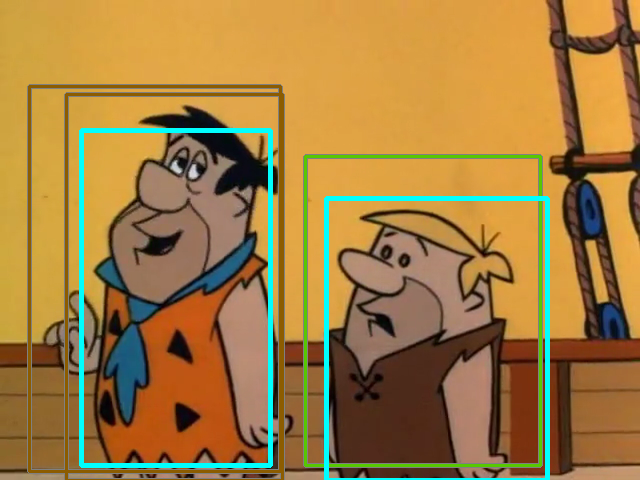

In [63]:
# aid = random.choice(filtered_out_single_vote)
# aid = 's_05_e_02_shot_016555_016629'
# aid = 's_06_e_07_shot_020636_020710'

filtered_out_anno = annotations_by_frame[rev_aids[0]]

review_single = {}

single_frame_image, consensus_boxes, labels = draw_image_and_labels(filtered_out_anno, cluster_from_nms)
img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
Image.fromarray(single_frame_image).save(img_path)
label_choices = select_labels(consensus_boxes, labels)
avg_votes = np.mean([box['votes'] for box in consensus_boxes])
avg_votes = np.nan_to_num(avg_votes)
possible_labels = [c['possible_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
chosen_labels = [c['chosen_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
review_single[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
rev_page = generate_review_page(review_single, 'dummy.html')
print([[box['label'] for box in json.loads(anno['characterBoxes'])] for anno in filtered_out_anno])

# HTML(rev_page.replace('review_frames/', 'review_results/review_frames/'))
Image.fromarray(single_frame_image)

In [57]:
filtered_out_anno

[{'asgmt_id': '3FFJ6VRIL2OCB2JC77EF4LHMZSX0IB',
  'characterBoxes': '[{"left":142,"top":54,"width":356,"height":390,"label":"barney"}]',
  'h_id': '33NKDW9FFYIQ855TS72YDCBHA78XC3',
  'stillID': 's_01_e_02_shot_003934_004008_40.png',
  'worker_id': 'A1QP6651C4Q8NS'},
 {'asgmt_id': '32Z9ZLUT1MKXIO0B3AY5UACPXIYOHW',
  'characterBoxes': '[{"left":170,"top":20,"width":314,"height":460,"label":"fred"}]',
  'h_id': '33NKDW9FFYIQ855TS72YDCBHA78XC3',
  'stillID': 's_01_e_02_shot_003934_004008_40.png',
  'worker_id': 'A3R6KO03P9QLNO'},
 {'asgmt_id': '3H8DHMCCWABXGHAUJMNMW8GILLWDKT',
  'characterBoxes': '[{"left":193,"top":42,"width":298,"height":438,"label":"barney"}]',
  'h_id': '33NKDW9FFYIQ855TS72YDCBHA78XC3',
  'stillID': 's_01_e_02_shot_003934_004008_40.png',
  'worker_id': 'A3UPV16IECELHV'}]

# annotation flaw hists

In [240]:
# A histogram with the following bins for entire dataset:
# 1. # boxes = 3 x # characters detected. Each box has 3 votes. ------- This may also contain an error, but no way to fix this.
# 2. 1 box lies outside of consensus and it is Empty Frame
# 3. 2 boxes lies outside of consensus and they are Empty Frame
# 4. 3+ boxes lies outside of consensus and they are Empty Frame
# 5/6/7. 1/2/3+ box lies outside of consensus and it is Main char
# 8/9/10. 1/2/3+ box lies outside of consensus and it is Other char

In [827]:
def compute_raw_anno_stats(raw_anno):
    total_box_count = 0
    empty_frame_count = 0
    other_char_labels = 0
    main_char_labels = 0
    for anno in raw_anno:
        for char in json.loads(anno['characterBoxes']):
            total_box_count += 1
            if char['label'] == 'empty frame':
                empty_frame_count += 1
            elif char['label'] in main_characters:
                main_char_labels += 1
            else:
                other_char_labels += 1
    return {'total_boxes': total_box_count, 'empty_frame_count' : empty_frame_count, 'main_char_labels': main_char_labels, 'other_char_labels': other_char_labels}

In [1101]:
vid_bins = {
    'bin_01_vids': [],
    'bin_02_vids': [],
    'bin_03_vids': [],
    'bin_04_vids': [], 
    'bin_05_vids': [],
    'bin_06_vids': [],
    'bin_07_vids': [],
    'bin_08_vids': [],
    'bin_09_vids': [],
    'bin_10_vids': [],
    'bin_11_vids': [],
}

# for aid, animation_annos in tqdm(list(st3_anno_by_frame.items())):
for aid, animation_annos in tqdm(list(annotations_by_frame.items())):
    try:
#         if aid != 's_06_e_05_shot_023039_023113':
#             continue
        consensus_boxes, labels = cluster_and_label(animation_annos, cluster_from_nms)
        label_choices = select_labels(consensus_boxes, labels)
        raw_anno_stats = compute_raw_anno_stats(animation_annos)
        box_remainders = max(raw_anno_stats['total_boxes'] - (len(consensus_boxes) * 3), 0)
        vote_counts = set([box['votes'] for box in consensus_boxes])
        con_box_votes = set([box['votes'] for box in consensus_boxes])
        con_box_idxs = set([box['idx'] for box in consensus_boxes])  
        other_main_box_votes = [box['label'] for box in labels if 'votes' in box.keys() and box['idx'] not in con_box_idxs if box['label'] in main_characters]
        other_minor_box_votes = [box['label'] for box in labels if 'votes' in box.keys() and box['idx'] not in con_box_idxs if box['label'] not in main_characters]
        if box_remainders == 0 and vote_counts == set([3]):
            vid_bins['bin_01_vids'].append(aid)
        elif box_remainders == 0  and vote_counts == set([3, 2]):
            vid_bins['bin_09_vids'].append(aid)
        elif not other_main_box_votes and not other_minor_box_votes and not raw_anno_stats['empty_frame_count']:
                vid_bins['bin_11_vids'].append(aid)
        else:
            if raw_anno_stats['empty_frame_count'] == 0:
                if not other_main_box_votes:
                    if len(other_minor_box_votes) == 1:
                        vid_bins['bin_06_vids'].append(aid)
                    elif len(other_minor_box_votes) >= 2:
                        vid_bins['bin_07_vids'].append(aid)
                elif not other_minor_box_votes:
                    if len(other_main_box_votes) == 1:
                        vid_bins['bin_04_vids'].append(aid)
                    elif len(other_main_box_votes) >= 2:
                        vid_bins['bin_05_vids'].append(aid)
                else:
                    if len(other_main_box_votes + other_minor_box_votes) >= 2:
                        vid_bins['bin_08_vids'].append(aid)
            else:
                if not other_main_box_votes and not other_minor_box_votes:
                    if raw_anno_stats['total_boxes'] == raw_anno_stats['empty_frame_count']:
                        vid_bins['bin_10_vids'].append(aid)
                    elif raw_anno_stats['empty_frame_count'] == 1:
                        vid_bins['bin_02_vids'].append(aid)
                    elif raw_anno_stats['empty_frame_count'] >= 2:
                        vid_bins['bin_03_vids'].append(aid)
                else:
                    other_flaws = len(other_main_box_votes + other_main_box_votes) + raw_anno_stats['empty_frame_count']
                    vid_bins['bin_08_vids'].append(aid)
    except IndexError:
        vid_bins['bin_08_vids'].append(aid)

100%|██████████| 20000/20000 [00:10<00:00, 1949.65it/s]


In [1102]:
# vid_bins

In [1103]:
# 1. # boxes = 3 x # characters detected. Each box has 3 votes. ------- This may also contain an error, but no way to fix this.
# 2. 1 box lies outside of consensus and it is Empty Frame
# 3. 2+ boxes lies outside of consensus and they are all Empty Frame
# 4/5. 1/2+ box lies outside of consensus and all are Main char
# 6/7. 1/2+ box lies outside of consensus and it all are Other char
# 8. 2+ box lies outside of consensus and they are a mix of other/main/empty
# 9: 2+ characters detected, but at least one has < 3: votes
# 10. Empty frame (consensus) (edited)

In [1104]:
# vid_bins

In [1106]:
sum([len(v) for v in vid_bins.values()])

20000

In [1157]:
pickle_this(vid_bins, 'original_large_batch_bin_assgmts.pkl')

In [1107]:
vids_accounted = [v for v_list in vid_bins.values() for v in v_list]

In [1108]:
unac = set(annotations_by_frame.keys()).difference(vids_accounted)

In [1109]:
unac

set()

In [1110]:
vid_bins['bin_12_vids'] = list(unac)

In [1124]:
vid_bin_counts = {k.replace('_vids', ''): len(v) for k, v in vid_bins.items() if v}

In [1125]:
bin_series = pd.Series(vid_bin_counts).sort_index()

In [1126]:
vid_bin_counts

{'bin_01': 9456,
 'bin_02': 1176,
 'bin_03': 133,
 'bin_04': 1801,
 'bin_05': 898,
 'bin_06': 391,
 'bin_07': 131,
 'bin_08': 1919,
 'bin_09': 2863,
 'bin_10': 663,
 'bin_11': 569}

In [1127]:
fig_labels = {
    'fig_title': 'Annotation Flaws', 
    'x_label': '',
    'y_label': '# animations'
}

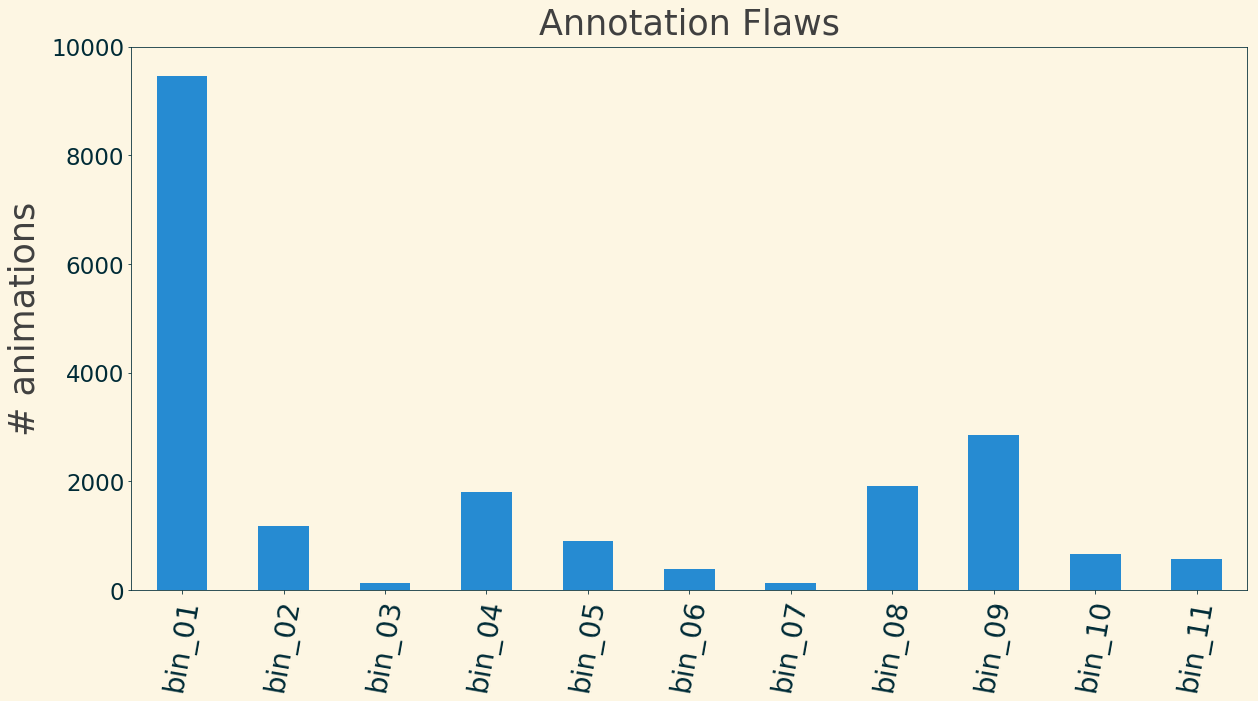

In [1128]:
flaw_hist = bin_series.plot(kind='bar')
plt.xticks(rotation=80) 
plt.ylim(0, 10000)
make_standard_fig(flaw_hist, fig_labels)

In [1020]:
1. #boxes = 3 x # characters detected. Each box has 3 votes. ------- This may also contain an error, but no way to fix this.
2. 1 box lies outside of consensus and it is Empty Frame
3. 2+ boxes lies outside of consensus and they are all Empty Frame
4/5. 1/2+ box lies outside of consensus and all are Main char
6/7. 1/2+ box lies outside of consensus and it all are Other char
8. 2+ box lies outside of consensus and they are a mix of other/main/empty
9: 2+ characters detected, but at least one has < 3: votes
10. Empty frame (consensus)
11. extra annotation

In [511]:
# 1. # boxes = 3 x # characters detected. Each box has 3 votes. ------- This may also contain an error, but no way to fix this.
# 2. 1 box lies outside of consensus and it is Empty Frame
# 3. 2 boxes lies outside of consensus and they are Empty Frame
# 4. 3+ boxes lies outside of consensus and they are Empty Frame
# 5/6/7. 1/2/3+ box lies outside of consensus and it is Main char
# 8/9/10. 1/2/3+ box lies outside of consensus and it is Other char

In [ ]:
review_seq = {}
error_frames = []
# for aid, animation_annos in tqdm(random.sample(list(annotations_by_frame.items()), 200)):
for aid, animation_annos in tqdm(list(st3_anno_by_frame.items())):
    single_frame_image, consensus_boxes, labels = draw_image_and_labels(animation_annos, cluster_from_nms)
    img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
#     single_frame_image.save(img_path)
    label_choices = select_labels(consensus_boxes, labels)
    avg_votes = np.mean([box['votes'] for box in consensus_boxes])
    avg_votes = np.nan_to_num(avg_votes)
    possible_labels = [c['possible_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
    chosen_labels = [c['chosen_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
    review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
    raw_anno_stats = compute_raw_anno_stats(animation_annos)
    print(con)
    
#     except:
#         error_frames.append(aid)

# rev_page = generate_review_page(review_seq, 'bbox_review_new_st3_beta.html')

In [1158]:
# Vid selection and cleaning by flaw bin

# Vid selection and cleaning by flaw bin

In [1159]:
vid_bins.keys()

dict_keys(['bin_01_vids', 'bin_02_vids', 'bin_03_vids', 'bin_04_vids', 'bin_05_vids', 'bin_06_vids', 'bin_07_vids', 'bin_08_vids', 'bin_09_vids', 'bin_10_vids', 'bin_11_vids', 'bin_12_vids'])

In [1751]:
bin4_annotations = {k: v for k, v in annotations_by_frame.items() if k in vid_bins['bin_04_vids']}
bin5_annotations = {k: v for k, v in annotations_by_frame.items() if k in vid_bins['bin_05_vids']}
bin6_annotations = {k: v for k, v in annotations_by_frame.items() if k in vid_bins['bin_06_vids']}
bin7_annotations = {k: v for k, v in annotations_by_frame.items() if k in vid_bins['bin_07_vids']}

In [1725]:
len(bin6_annotations)

391

In [1752]:
fn = -1

In [1785]:
vid_bin_counts

{'bin_01': 9456,
 'bin_02': 1176,
 'bin_03': 133,
 'bin_04': 1801,
 'bin_05': 898,
 'bin_06': 391,
 'bin_07': 131,
 'bin_08': 1919,
 'bin_09': 2863,
 'bin_10': 663,
 'bin_11': 569}

[['barney', 'man with blue hair', 'woman with hat', 'man in green shirt'], ['empty frame', 'empty frame', 'empty frame', 'barney'], ['barney', 'man in green cothes', 'woman in blue hat', 'man with blue hair and glasses']]


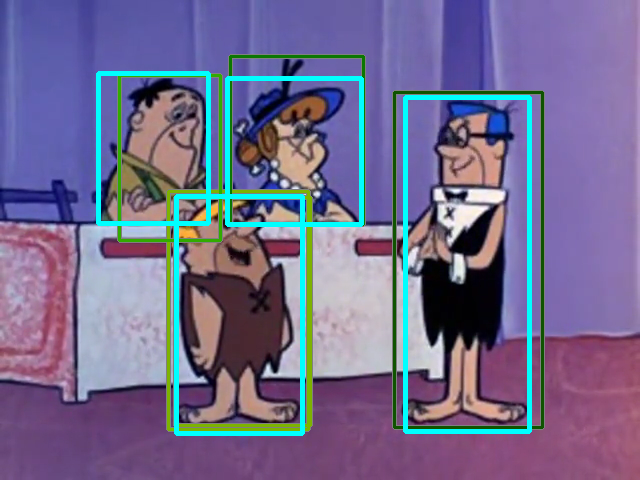

In [1786]:
fn += 1
aid, filtered_out_anno = list(bin7_annotations.items())[fn]
frame_id = 's_02_e_29_shot_014705_014779'
aid, filtered_out_anno = frame_id, annotations_by_frame[frame_id]
review_single = {}

single_frame_image, consensus_boxes, labels = draw_image_and_labels(filtered_out_anno, cluster_from_nms)
promoted_char = promote_minor_boxes(labels, consensus_boxes)
# if promoted_char
img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
# single_frame_image.save(img_path)
label_choices = select_labels(consensus_boxes, labels)
avg_votes = np.mean([box['votes'] for box in consensus_boxes])
avg_votes = np.nan_to_num(avg_votes)
possible_labels = [c['possible_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
chosen_labels = [c['chosen_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
review_single[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
rev_page = generate_review_page(review_single, 'dummy.html')
print([[box['label'] for box in json.loads(anno['characterBoxes'])] for anno in filtered_out_anno])

HTML(rev_page.replace('review_frames/', 'review_results/review_frames/'))
if promoted_char:
    return_frame = draw_new_con_box(single_frame_image, promoted_char['box'].reshape(2, 2))
else:
    return_frame = Image.fromarray(single_frame_image)
return_frame

In [1784]:
review_seq = {}
error_frames = []
select_bin = 'bin_07_vids'
print(select_bin)
bin_annotations = {k: v for k, v in annotations_by_frame.items() if k in vid_bins[select_bin]}
for aid, animation_annos in tqdm(random.sample(list(bin_annotations.items()), min(len(bin_annotations), 100))):
    single_frame_image, consensus_boxes, labels = draw_image_and_labels(animation_annos, cluster_from_nms)
    promoted_char = promote_minor_boxes(labels, consensus_boxes)
    img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
#     single_frame_image.save(img_path)
    label_choices = select_labels(consensus_boxes, labels)
    avg_votes = np.mean([box['votes'] for box in consensus_boxes])
    avg_votes = np.nan_to_num(avg_votes)
    possible_labels = [c['possible_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
    chosen_labels = [c['chosen_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
    review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
    if promoted_char:
        save_image = draw_new_con_box(single_frame_image, promoted_char['box'].reshape(2, 2))
    else:
        save_image = Image.fromarray(single_frame_image)
    save_image.save(img_path)
#     except:
#         error_frames.append(aid)

rev_page = generate_review_page(review_seq, 'bboxes_new_selections_' + select_bin + '.html')

  0%|          | 0/100 [00:00<?, ?it/s]

bin_07_vids


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


In [1686]:
import cv2
from amt_utils.bboxes import characterbox_to_box
from amt_utils.bboxes import comp_boxes_iou
from amt_utils.bboxes import comp_boxes_iou
from amt_utils.bboxes import box_area_ratio
from amt_utils.bboxes import box_aspect_ratio
from amt_utils.bboxes import compute_intersection

In [1777]:
def check_iou(other_char, consensus_boxes, iou_thresh):
#     print([comp_boxes_iou(other_char['box'], con_box['box']) for con_box in consensus_boxes])
    return max([comp_boxes_iou(other_char['box'], con_box['box']) for con_box in consensus_boxes] + [0.0]) > iou_thresh


def check_subset_or_superset(other_char, consensus_boxes, intersect_thresh):
    interserctions = [compute_intersection(other_char['box'].reshape(2, 2), con_box['box'].reshape(2, 2)) / min(other_char['area'], con_box['area'])for con_box in consensus_boxes]
    return max(interserctions + [0.0]) > intersect_thresh


def check_labels(other_char, consensus_boxes):
    return sum([other_char['label'] == con_box['label'] for con_box in consensus_boxes])


def make_checks(oc, cb, iou_t, int_t):
#     print(check_labels(oc, cb), check_subset_or_superset(oc, cb, int_t), check_iou(oc, cb, iou_t))
    return check_labels(oc, cb) + check_subset_or_superset(oc, cb, int_t) + check_iou(oc, cb, iou_t)

def select_multiple_boxes(possible_new_boxes):
    sorted_boxes = sorted(possible_new_boxes, key=lambda x: x['area'], reverse=True)
    for idx in range(0, len(sorted_boxes) -1):
#         print('idx', idx)
        b2 = possible_new_boxes[idx + 1]
        b1 = possible_new_boxes[idx]
        if box_area_ratio(b2['box'], b1['box']) > 2.0 * (box_aspect_ratio(b2['box']) / box_aspect_ratio(b1['box']))**2:
            return b2
        return b1

In [1778]:
def promote_main_boxes(all_boxes, consensus_boxes, iou_thresh=0.6, area_thresh = 0.7):
    con_box_idxs = set([box['idx'] for box in consensus_boxes])  
    other_main_chars = [box for box in labels if 'votes' in box.keys() and box['idx'] not in con_box_idxs if box['label'] in main_characters]
    potential_new_chars = [other_char for other_char in other_main_chars if not make_checks(other_char, consensus_boxes, iou_thresh, area_thresh)]
#     print(potential_new_chars)
    if len(potential_new_chars) < 1:
        return None
    if len(potential_new_chars) == 1:
        return potential_new_chars[0]
    else:
        return select_multiple_boxes(potential_new_chars)

In [1779]:
def promote_minor_boxes(all_boxes, consensus_boxes, iou_thresh=0.6, area_thresh = 0.7):
    con_box_idxs = set([box['idx'] for box in consensus_boxes])  
    other_main_chars = [box for box in labels if 'votes' in box.keys() and box['idx'] not in con_box_idxs if box['label'] not in main_characters]
    potential_new_chars = [other_char for other_char in other_main_chars if not make_checks(other_char, consensus_boxes, iou_thresh, area_thresh)]
#     print(potential_new_chars)
    if len(potential_new_chars) < 1:
        return None
    if len(potential_new_chars) == 1:
        return potential_new_chars[0]
    else:
        return select_multiple_boxes(potential_new_chars)

In [1484]:
promote_single_box(labels, consensus_boxes)

[0.0]


In [1386]:
promote_single_box(labels, consensus_boxes)

[0.2694940841905698, 0.0]
[0.71631205673758869, 0.0]
True True
[0.2694940841905698, 0.0]
[0.71631205673758869, 0.0]


{'area': 21432,
 'box': array([336, 143, 488, 284]),
 'idx': 0,
 'label': 'barney',
 'votes': 1}

In [1318]:
def draw_new_con_box(img_frame, new_con_box):
#     max_height, max_width, channels = img_frame.shape
#     limit_rect(worker_box, max_width, max_height)
    cv2.rectangle(img_frame, tuple(new_con_box[0]), tuple(new_con_box[1]), color=(0, 0, 255), thickness=3)
    return Image.fromarray(img_frame)

# bonus cost estimate

In [124]:
main_characters = [
    "Fred",
    "Wilma",
    "Mr Slate",
    "Barney",
    "Betty",
    "Pebbles",
    "Dino",
    "Baby Puss",
    "Hoppy",
    "Bamm Bamm",
]

empty_characters = ['no characters', 'empty frame']
main_characters += empty_characters
main_characters = [char.lower() for char in main_characters]

In [183]:
frame_cost = 0
bonus_cost = 0
for anno in list(review_seq.values()):
    frame_cost += 0.05 * 3
#     print(anno)
    bonus_cost += len([char for char in anno['chosen_labels'] if char not in main_characters]) * 0.03

In [184]:
print(frame_cost, bonus_cost)
frame_cost + bonus_cost

80.25000000000018 3.659999999999995


83.91000000000018

In [200]:
frame_count = []
for anno in list(review_seq.values()):
    frame_count += len([char for char in anno['chosen_labels'] if char not in empty_characters])

In [201]:
frame_count

787

# HTML Review

In [18]:
review_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h3>score: {{clip[2]}}      rank: {{clip[3]}}</h3>
        <p>{{clip[1]}}</p>
        <p>{{clip[4]}}</p>
        <p>{{clip[5]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

review_single_frame_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <p>{{clip[1]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

review_subtask_comp = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h4>original 3 frames:</h4>
        <p>{{clip[1]}}</p>
        <h4>new frames + original middle:</h4>
        <p>{{clip[2]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

In [19]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'


def make_uri(clip_id, s3_base='review_frames/', file_ext='_rev.png'):
    s3_uri = s3_base + clip_id + file_ext
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag

def make_comp_uri(clip_id, s3_base=s3_base_path):
    s3_uri = s3_base + clip_id
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag


def generate_review_page(review_seq, out_page='bbox_review.html'):
    images_sorted_by_conf = [make_uri(img[0]) for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    sorted_clip_ids = [img[0] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    votes = [img[1]['votes'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    chosen_labels = [img[1]['chosen_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    possible_labels = [img[1]['possible_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    
    send_to_template = zip(sorted_clip_ids, images_sorted_by_conf, votes, range(1, len(votes) + 1)[::-1], chosen_labels, possible_labels)
    env = Environment()
    template =  j2env.from_string(review_page_html)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html

def generate_single_image_review_page(rev_seq, out_page='bbox_review.html'):
    images_sorted_by_conf = [make_uri(img) for img in rev_seq]
    send_to_template = zip(rev_seq, images_sorted_by_conf)
    env = Environment()
    template =  j2env.from_string(review_single_frame_page_html)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html

def generate_subtask_review(rev_seq, out_page='review_subtask_comp.html'):
    env = Environment()
    rev_seq = [(rev[0], make_comp_uri(rev[1]), make_comp_uri(rev[2])) for rev in rev_seq]
    template =  j2env.from_string(review_subtask_comp)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = rev_seq)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
        
    return page_html

In [20]:
# page_html = generate_subtask_review(subtask_rev_seq)

# hide

In [836]:
# THREE FRAME REVIEW



# review_seq = {}
# error_frames = []
# for aid, animation_annos in tqdm(list(annotations_by_frame.items())[:5]):
#     try:
#         three_frame_img, consensus_boxes, labels = draw_animation_seq(animation_annos, cluster_from_nms)
#         avg_votes = np.mean([box['votes'] for frame in consensus_boxes for box in frame])
#         possible_labels = [c['possible_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#         chosen_labels = [c['chosen_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#         review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
#         img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
#         three_frame_img.save(img_path)
#     except:
#         error_frames.append(aid)

# rev_page = generate_review_page('bbox_review_new_8_11_small.html')


In [ ]:
vote_series = pd.Series([vote for vote in review_seq.values()])

In [13]:
# assignments =[]
# for assignment_triple in list(results.values()):
#     assignments.extend(assignment_triple)

# assignment_results = [create_result(ar) for ar in assignments]

# characters_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

# main_characters =  {"fred",
#              "barney",
#               "wilma",
#               "betty",
#               "pebbles",
#               "bamm bamm",
#               "dino",
#               "mr slate",
#               "baby puss",
#               "hoppy",
#               "no characters"}

# def all_main(char_set, main_chars=main_characters):
#     return not bool(char_set.difference(main_chars))

# char_df = pd.DataFrame(characters_present)

# char_df['all_main'] = char_df['characters'].apply(lambda x: all_main(x))

# all_chars = [c for char_list in char_df['characters'].apply(lambda x: list(x)).tolist() for c in char_list]
# char_counts = pd.Series(all_chars).value_counts()

# # char_counts.hist(bins = 30, log=True)

# char_df['n_chars'] = char_df['characters'].apply(lambda x: len(x))

# prolific_workers = char_df['w_id'].value_counts().index.tolist()[:5]

# grouped_by_still = char_df.groupby('still_id')

# agg_df = grouped_by_still.aggregate(len)

# import scipy

# agged_on_mode = grouped_by_still.agg(lambda x: scipy.stats.mode(x))
# consensus_results_df = agged_on_mode.reset_index()

# consensus_results_df['count_mode'] = consensus_results_df['n_chars'].apply(lambda x: x[1][0])

# consensus_results_df

# consensus_results_df['mode_count'] = consensus_results_df['characters'].apply(lambda x: x[1][0])

# consensus_results_df['all_agree'] = consensus_results_df['count_mode'] == 3
# consensus_results_df['two_agree'] = consensus_results_df['count_mode'] == 2

In [87]:
# all_main_annotations_by_frame = {}
# no_main_annotations_by_frame = {}
# mixed_all_frames = {}


# for aid, annos in annotations_by_frame.items():
#     still_ids = [still['stillID'] for still in annos]
#     annos = [anno for anno in annos]
#     if len([sid for sid in still_ids if sid in all_agree_set]) == 9:
#         all_main_annotations_by_frame[aid] = annos
#     elif len([sid for sid in still_ids if sid in not_main]) == 9:
#         no_main_annotations_by_frame[aid] = annos
#     else: 
#         mixed_all_frames[aid] = annos

# print(len(all_main_annotations_by_frame), len(no_main_annotations_by_frame), len(mixed_all_frames))

In [ ]:
# char_count_df = consensus_results_df[consensus_results_df['count_mode'] == 3]

# # consensus_results_df[agree_all_main]['characters'].apply(lambda x: x[1][0]).value_counts()

# not_main =set(consensus_results_df[~agree_all_main]['still_id'].tolist())

# not_main_df = char_df[char_df['still_id'].isin(not_main)]

# consensus_results_df.head(1)

# agree_all_main = consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 3 

# all_agree = consensus_results_df[agree_all_main][consensus_results_df[agree_all_main]['all_agree']]
# disagree = consensus_results_df[agree_all_main][~consensus_results_df[agree_all_main]['all_agree']]







# all_agree_set = set(all_agree['still_id'].tolist())

# count_all_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 3]['still_id'].tolist())
# count_two_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 2]['still_id'].tolist())
# count_none_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 1]['still_id'].tolist())

# conflict_images = set(disagree['still_id'].tolist())

# conflict_df = char_df[char_df['still_id'].isin(conflict_images)]

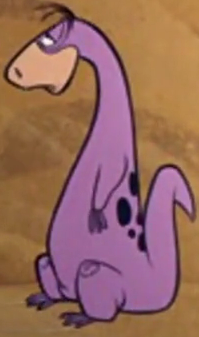

In [1156]:
import PIL.Image as Image
import requests

image_n = 10


s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/subtask_frames/'


image_url = s3_base_path + 's_01_e_04_shot_012010_012084_70.png'
image_url= s3_base_path + 's_02_e_15_shot_011377_011451_char_0_taskb.png'
Image.open(requests.get(image_url, stream=True).raw)